In [1]:
# Install sentence-transformers for text embedding
!pip install -U sentence-transformers

# Imports
import os
import glob
import random
import string
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Function to fix random seeds for reproducibility
def set_seeds(seed=2025):
    os.environ['PYTHONHASHSEED'] = str(seed)        # For Python internal hash-based operations
    random.seed(seed)                               # Python built-in random seed
    np.random.seed(seed)                            # NumPy random seed
    tf.random.set_seed(seed)                        # TensorFlow random seed

# Set seeds
set_seeds(2026)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.

2025-07-07 07:37:46.664602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751873867.023767      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751873867.121098      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def convert_folder_to_csv(base_path: str, label_df: pd.DataFrame = None, split: str = "train") -> pd.DataFrame:
    """
    Reads text files from article folders and combines them into a dataframe.
    
    Args:
        base_path: Root directory containing 'train' or 'test' folders.
        label_df: DataFrame containing labels (optional, for train split).
        split: "train" or "test" to select folder.

    Returns:
        Pandas DataFrame with columns: id, text1, text2, (optional) real_text_id.
    """
    data = []

    # Get sorted list of article folders, e.g., article_0, article_1, ...
    folders = sorted(glob.glob(os.path.join(base_path, split, "article_*")))

    for i, folder in enumerate(folders):
        # Paths to the two text files in each article folder
        file_1_path = os.path.join(folder, "file_1.txt")
        file_2_path = os.path.join(folder, "file_2.txt")

        # Read the content of both text files
        with open(file_1_path, "r", encoding="utf-8") as f1, open(file_2_path, "r", encoding="utf-8") as f2:
            text1 = f1.read().strip()
            text2 = f2.read().strip()

        # Append label if available (training mode)
        if label_df is not None:
            real_id = label_df.iloc[i]["real_text_id"]
            data.append({"id": i, "text1": text1, "text2": text2, "real_text_id": real_id})
        else:
            data.append({"id": i, "text1": text1, "text2": text2})

    return pd.DataFrame(data)

# Load training labels CSV
label_df = pd.read_csv(r'/kaggle/input/fake-or-real-the-impostor-hunt/data/train.csv')

# Convert train and test folder data to DataFrames
train = convert_folder_to_csv('/kaggle/input/fake-or-real-the-impostor-hunt/data', label_df, "train")
test = convert_folder_to_csv('/kaggle/input/fake-or-real-the-impostor-hunt/data', None, "test")

# Save dataframes as CSV for easier reloading
train_path = "/kaggle/working/train_data.csv"
test_path  = "/kaggle/working/test_data.csv"

train.to_csv(train_path, index=False)
test.to_csv(test_path, index=False)

print(f'Train csv saved at {train_path}')
print(f'Test csv saved at {test_path}')

Train csv saved at /kaggle/working/train_data.csv
Test csv saved at /kaggle/working/test_data.csv


In [3]:
# Load saved train and test data CSVs
df = pd.read_csv(train_path)

# Drop any rows with missing text data, just in case
df = df.dropna(subset=["text1", "text2"]).reset_index(drop=True)

test_df = pd.read_csv(test_path)

# Convert label values: 1 -> 1 (real), 2 -> 0 (fake)
df["label"] = df["real_text_id"].apply(lambda x: 1 if x == 1 else 0)

# Show first few rows for confirmation
df.head()

,id,text1,text2,real_text_id,label
0,0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...,1,1
1,1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...,2,0
2,2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...,1,1
3,3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...,2,0
4,4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...,2,0


In [4]:
# Load pre-trained SentenceTransformer model
model = SentenceTransformer("paraphrase-mpnet-base-v2")

# Generate embeddings for both text columns in train set
text1_embeddings = model.encode(df["text1"].tolist(), convert_to_numpy=True, show_progress_bar=True)
text2_embeddings = model.encode(df["text2"].tolist(), convert_to_numpy=True, show_progress_bar=True)

print(f'text1 shape : {text1_embeddings.shape}')  # e.g. (num_samples, 768)
print(f'text2 shape : {text2_embeddings.shape}')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

text1 shape : (93, 768)
text2 shape : (93, 768)


In [5]:
# Concatenate features: [text1_emb, text2_emb, absolute difference]
X = np.concatenate([
    text1_embeddings,
    text2_embeddings,
    np.abs(text1_embeddings - text2_embeddings)  # This helps capture similarity/difference
], axis=1)

# Target labels
y = df["label"].values

print(f'X shape : {X.shape}')  # Should be (num_samples, 768*3)
print(f'y shape : {y.shape}')

X shape : (93, 2304)
y shape : (93,)


In [6]:
# Stratified split to maintain label distribution
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=2025
)

print('X train shape : ', X_train.shape)
print('X val shape   : ', X_val.shape)
print('y train shape : ', y_train.shape)
print('y val shape   : ', y_val.shape)

X train shape :  (74, 2304)
X val shape   :  (19, 2304)
y train shape :  (74,)
y val shape   :  (19,)


In [7]:
# Use CPU explicitly (for Kaggle kernels that might default to GPU)
with tf.device('/CPU:0'):
    
    # Build simple MLP model for binary classification
    model_mlp = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.1)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.1)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")  # Output probability for binary class
    ])

    model_mlp.compile(
        optimizer='adam',
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # Early stopping callback to prevent overfitting
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=25,
        restore_best_weights=True,
        verbose=True
    )

    # Train model
    history = model_mlp.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        callbacks=[early_stop]
    )

I0000 00:00:1751873947.935418      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11954 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751873947.936030      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/100


I0000 00:00:1751873949.671227     102 service.cc:148] XLA service 0x7aa4f400caa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751873949.672564     102 service.cc:156]   StreamExecutor device (0): Host, Default Version


1/5 [=====>........................] - ETA: 7s - loss: 118.4388 - accuracy: 0.3125

I0000 00:00:1751873950.179743     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 2s 81ms/step - loss: 107.0356 - accuracy: 0.4054 - val_loss: 88.8144 - val_accuracy: 0.5263
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 79.7113 - accuracy: 0.5541 - val_loss: 65.3690 - val_accuracy: 0.5263
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 58.3453 - accuracy: 0.5405 - val_loss: 47.4054 - val_accuracy: 0.5263
Epoch 4/100
5/5 [==============================] - 0s 15ms/step - loss: 42.1350 - accuracy: 0.5541 - val_loss: 34.0273 - val_accuracy: 0.5263
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 30.1764 - accuracy: 0.5946 - val_loss: 24.3211 - val_accuracy: 0.5263
Epoch 6/100
5/5 [==============================] - 0s 15ms/step - loss: 21.5744 - accuracy: 0.7838 - val_loss: 17.4391 - val_accuracy: 0.4211
Epoch 7/100
5/5 [==============================] - 0s 16ms/step - loss: 15.4882 - accuracy: 0.6622 - val_loss: 12.6439 - val_accuracy: 0.5263
Epoch 8/100
5/5 [

In [8]:
# Encode test set text pairs using same SentenceTransformer model
test_text1_emb = model.encode(test_df["text1"].tolist(), convert_to_numpy=True, show_progress_bar=True)
test_text2_emb = model.encode(test_df["text2"].tolist(), convert_to_numpy=True, show_progress_bar=True)

# Create test features same way as train features
X_test = np.concatenate([
    test_text1_emb,
    test_text2_emb,
    np.abs(test_text1_emb - test_text2_emb)
], axis=1)

print(f'X test shape : {X_test.shape}')

# Predict with trained model on test features
with tf.device('/CPU:0'):
    test_preds = model_mlp.predict(X_test)

# Convert sigmoid outputs to class labels (threshold = 0.5)
# Recall: original labels are 1 for real, 2 for fake
test_df["real_text_id"] = test_preds
test_df["real_text_id"] = test_df["real_text_id"].apply(lambda x: 1 if x >= 0.5 else 2)

# Prepare submission file
submission = test_df[["id", "real_text_id"]]

# Check distribution of predicted labels
print(submission['real_text_id'].value_counts())

submission.to_csv("submission.csv", index=False)

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

X test shape : (1068, 2304)
34/34 [==============================] - 0s 2ms/step
real_text_id
1    558
2    510
Name: count, dtype: int64


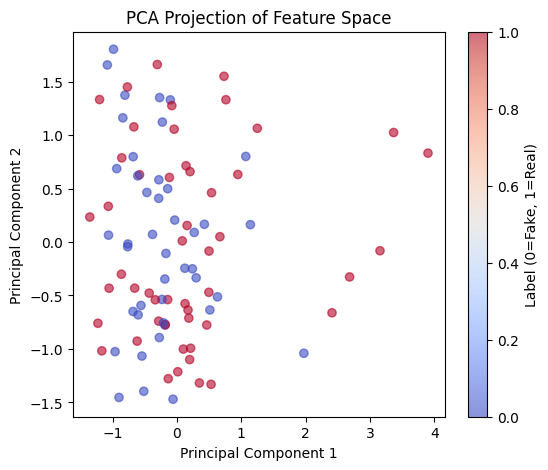

In [9]:
# Reduce high-dimensional features to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.title("PCA Projection of Feature Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Label (0=Fake, 1=Real)')
plt.show()